## EXPLORATORY DATA ANLYSIS PIPELINE

In [13]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [14]:
PROJECT_ROOT = Path.cwd().parents[0]
PROCESSED = PROJECT_ROOT / "data" / "processed"

In [15]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [16]:
# Target
cpj = pd.read_csv(PROCESSED / "target" / "target_journalist_killings.csv")

# Military
sipri = pd.read_csv(PROCESSED / "military" / "sipri_trade_register.csv")
mip = pd.read_csv(PROCESSED / "military" / "mip_us_interventions.csv")
ucdp = pd.read_csv(PROCESSED / "military" / "ucdp_esd_ty.csv")

# Colonial
coldat = pd.read_csv(PROCESSED / "colonial" / "coldat_colonial_ties.csv")

# Economic
aiddata = pd.read_csv(PROCESSED / "economic" / "aiddata_bilateral_flows.csv")
debt = pd.read_csv(PROCESSED / "economic" / "worldbank_bilateral_debt.csv")

# Control
oda = pd.read_csv(PROCESSED / "control-variable" / "oda_received_by_country.csv")

print("All datasets loaded!")
print(f"""
Dataset shapes:
- CPJ (target):     {cpj.shape}
- SIPRI (arms):     {sipri.shape}
- MIP (US interv):  {mip.shape}
- UCDP (global):    {ucdp.shape}
- COLDAT (colonial):{coldat.shape}
- AidData (aid):    {aiddata.shape}
- Debt:             {debt.shape}
- ODA (control):    {oda.shape}
""")

All datasets loaded!

Dataset shapes:
- CPJ (target):     (763, 4)
- SIPRI (arms):     (12953, 6)
- MIP (US interv):  (160, 7)
- UCDP (global):    (6484, 9)
- COLDAT (colonial):(160, 5)
- AidData (aid):    (75626, 5)
- Debt:             (19980, 7)
- ODA (control):    (5122, 5)



=== TEMPORAL COVERAGE ===

CPJ (target): 1992 - 2026
SIPRI: 1990 - 2024
MIP: 1990 - 2019
UCDP: 1990 - 2017
AidData: 1990 - 2013
Debt: 1990 - 2024
ODA: 1990 - 2023


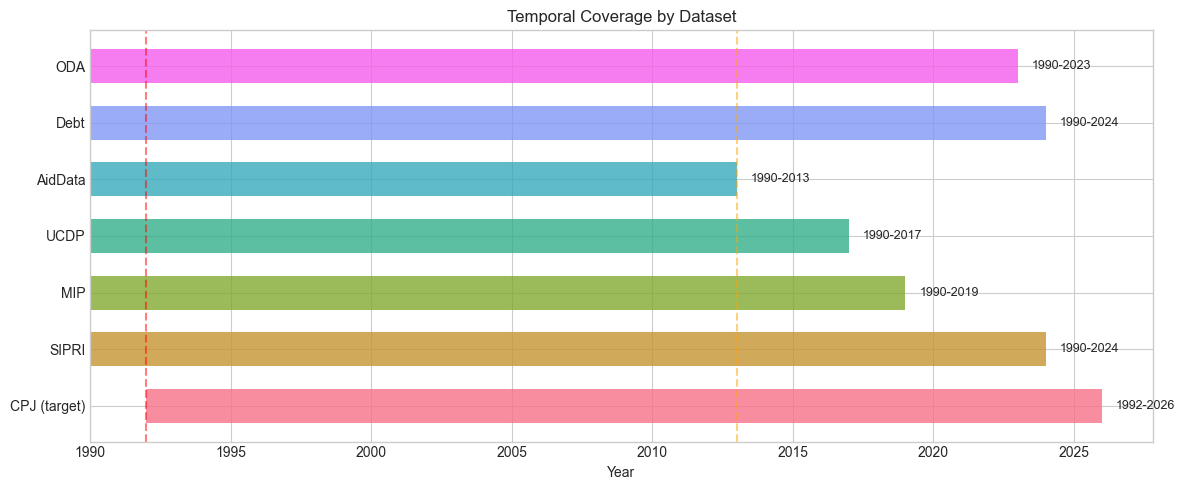


  NB AidData ends in 2013 - this limits our analysis window


In [17]:
print("=== TEMPORAL COVERAGE ===\n")

datasets = {
    'CPJ (target)': cpj['year'],
    'SIPRI': sipri['year'],
    'MIP': mip['start_year'],
    'UCDP': ucdp['year'],
    'AidData': aiddata['year'],
    'Debt': debt['year'],
    'ODA': oda['year'],
}

# Print ranges
for name, years in datasets.items():
    print(f"{name}: {int(years.min())} - {int(years.max())}")

# Visualize overlap
fig, ax = plt.subplots(figsize=(12, 5))

y_positions = range(len(datasets))
colors = sns.color_palette("husl", len(datasets))

for i, (name, years) in enumerate(datasets.items()):
    min_year, max_year = int(years.min()), int(years.max())
    ax.barh(i, max_year - min_year, left=min_year, height=0.6, 
            color=colors[i], alpha=0.8, label=name)
    ax.text(max_year + 0.5, i, f"{min_year}-{max_year}", va='center', fontsize=9)

ax.set_yticks(y_positions)
ax.set_yticklabels(datasets.keys())
ax.set_xlabel('Year')
ax.set_title('Temporal Coverage by Dataset')
ax.axvline(x=1992, color='red', linestyle='--', alpha=0.5, label='CPJ starts')
ax.axvline(x=2013, color='orange', linestyle='--', alpha=0.5, label='AidData ends')

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "outputs" / "temporal_coverage.png", dpi=150)
plt.show()

print("\n  NB AidData ends in 2013 - this limits our analysis window")

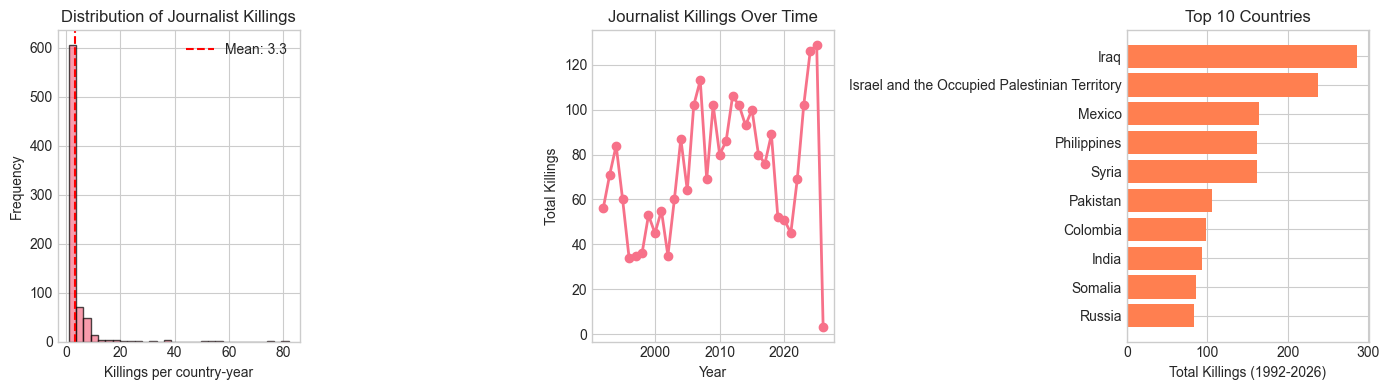


Target Variable Stats:
- Total killings: 2550
- Mean per country-year: 3.34
- Median: 2
- Max: 82
- Countries with any killings: 116
- Zero-inflated: 0 / 763 (0.0%)



In [18]:
#target variable distribution
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 4a. Distribution of killings per country-year
ax1 = axes[0]
ax1.hist(cpj['journalist_killings'], bins=30, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Killings per country-year')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Journalist Killings')
ax1.axvline(cpj['journalist_killings'].mean(), color='red', linestyle='--', label=f"Mean: {cpj['journalist_killings'].mean():.1f}")
ax1.legend()

# 4b. Killings over time
ax2 = axes[1]
yearly = cpj.groupby('year')['journalist_killings'].sum()
ax2.plot(yearly.index, yearly.values, marker='o', linewidth=2)
ax2.set_xlabel('Year')
ax2.set_ylabel('Total Killings')
ax2.set_title('Journalist Killings Over Time')

# 4c. Top 10 countries
ax3 = axes[2]
top_countries = cpj.groupby('Country')['journalist_killings'].sum().sort_values(ascending=True).tail(10)
ax3.barh(top_countries.index, top_countries.values, color='coral')
ax3.set_xlabel('Total Killings (1992-2026)')
ax3.set_title('Top 10 Countries')

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "outputs" / "cpj_distribution.png", dpi=150)
plt.show()

# Stats
print(f"""
Target Variable Stats:
- Total killings: {cpj['journalist_killings'].sum()}
- Mean per country-year: {cpj['journalist_killings'].mean():.2f}
- Median: {cpj['journalist_killings'].median():.0f}
- Max: {cpj['journalist_killings'].max():.0f}
- Countries with any killings: {(cpj.groupby('Country')['journalist_killings'].sum() > 0).sum()}
- Zero-inflated: {(cpj['journalist_killings'] == 0).sum()} / {len(cpj)} ({100*(cpj['journalist_killings'] == 0).sum()/len(cpj):.1f}%)
""")

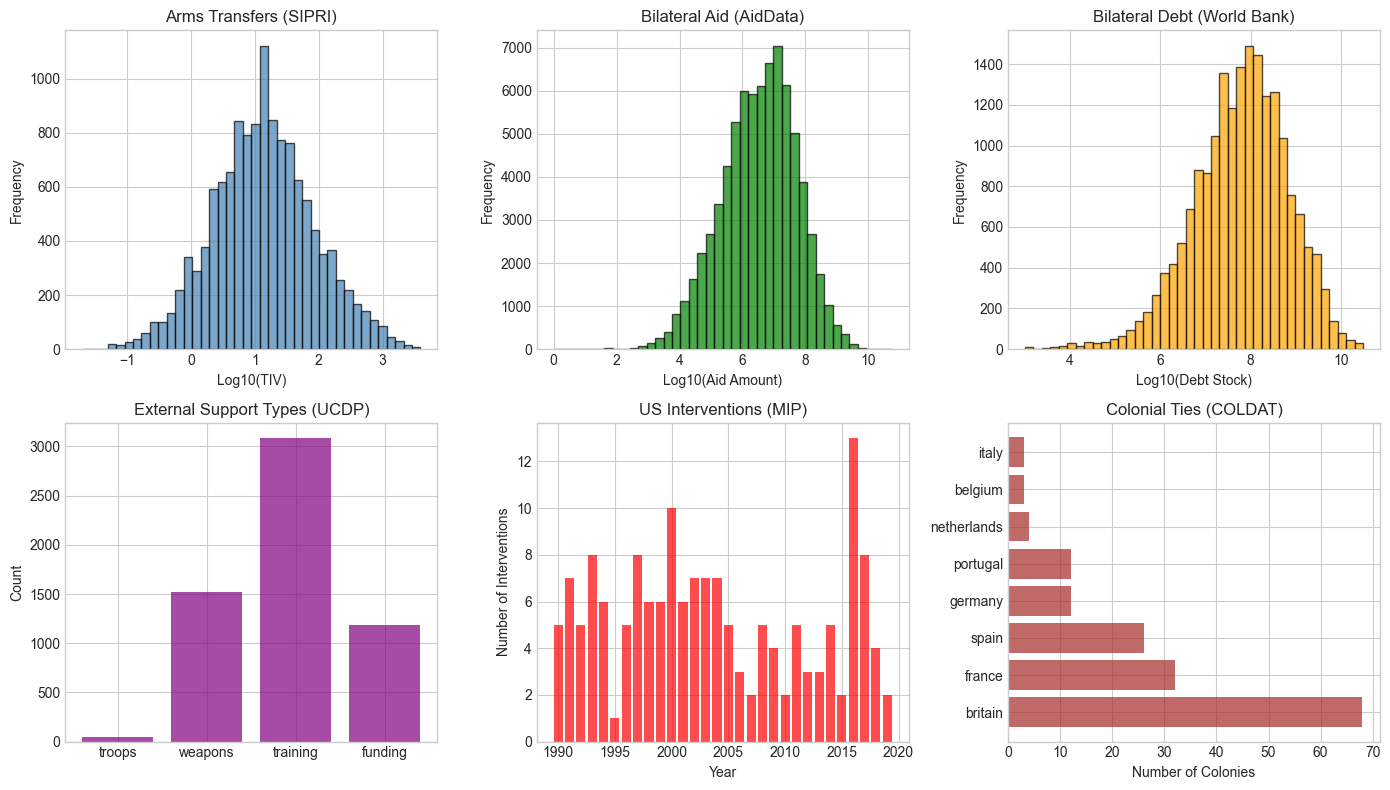

In [19]:
#predictor distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# 5a. SIPRI - Arms transfers
ax = axes[0, 0]
sipri_log = sipri[sipri['tiv'] > 0]['tiv'].apply(lambda x: np.log10(x))
ax.hist(sipri_log, bins=40, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Log10(TIV)')
ax.set_ylabel('Frequency')
ax.set_title('Arms Transfers (SIPRI)')

# 5b. AidData - Aid flows
import numpy as np
ax = axes[0, 1]
aid_log = aiddata[aiddata['aid_amount'] > 0]['aid_amount'].apply(lambda x: np.log10(x))
ax.hist(aid_log, bins=40, edgecolor='black', alpha=0.7, color='green')
ax.set_xlabel('Log10(Aid Amount)')
ax.set_ylabel('Frequency')
ax.set_title('Bilateral Aid (AidData)')

# 5c. Debt
ax = axes[0, 2]
debt_log = debt[debt['debt_stock'] > 0]['debt_stock'].apply(lambda x: np.log10(x))
ax.hist(debt_log, bins=40, edgecolor='black', alpha=0.7, color='orange')
ax.set_xlabel('Log10(Debt Stock)')
ax.set_ylabel('Frequency')
ax.set_title('Bilateral Debt (World Bank)')

# 5d. UCDP - Interventions by type
ax = axes[1, 0]
support_types = ['troops', 'weapons', 'training', 'funding']
support_counts = [ucdp[col].sum() for col in support_types]
ax.bar(support_types, support_counts, color='purple', alpha=0.7)
ax.set_ylabel('Count')
ax.set_title('External Support Types (UCDP)')

# 5e. MIP - US Interventions over time
ax = axes[1, 1]
mip_yearly = mip.groupby('start_year').size()
ax.bar(mip_yearly.index, mip_yearly.values, color='red', alpha=0.7)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Interventions')
ax.set_title('US Interventions (MIP)')

# 5f. Colonial ties by colonizer
ax = axes[1, 2]
colonial_counts = coldat['colonizer'].value_counts()
ax.barh(colonial_counts.index, colonial_counts.values, color='brown', alpha=0.7)
ax.set_xlabel('Number of Colonies')
ax.set_title('Colonial Ties (COLDAT)')

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "outputs" / "predictor_distributions.png", dpi=150)
plt.show()

In [20]:
#merge coverage check
# Get unique country-years from each dataset
cpj_cy = set(zip(cpj['iso3'], cpj['year']))
sipri_cy = set(zip(sipri['recipient_iso3'], sipri['year']))
ucdp_cy = set(zip(ucdp['target_iso3'], ucdp['year']))
aiddata_cy = set(zip(aiddata['recipient_iso3'], aiddata['year']))
debt_cy = set(zip(debt['debtor_iso3'], debt['year']))
oda_cy = set(zip(oda['iso3'], oda['year']))

print("=== COUNTRY-YEAR COVERAGE ===\n")
print(f"CPJ (target):    {len(cpj_cy)} country-years")
print(f"SIPRI:           {len(sipri_cy)} country-years")
print(f"UCDP:            {len(ucdp_cy)} country-years")
print(f"AidData:         {len(aiddata_cy)} country-years")
print(f"Debt:            {len(debt_cy)} country-years")
print(f"ODA:             {len(oda_cy)} country-years")

# Check overlap with target (CPJ)
print("\n=== OVERLAP WITH CPJ (target) ===\n")
print(f"CPJ ∩ SIPRI:     {len(cpj_cy & sipri_cy)} ({100*len(cpj_cy & sipri_cy)/len(cpj_cy):.1f}%)")
print(f"CPJ ∩ UCDP:      {len(cpj_cy & ucdp_cy)} ({100*len(cpj_cy & ucdp_cy)/len(cpj_cy):.1f}%)")
print(f"CPJ ∩ AidData:   {len(cpj_cy & aiddata_cy)} ({100*len(cpj_cy & aiddata_cy)/len(cpj_cy):.1f}%)")
print(f"CPJ ∩ Debt:      {len(cpj_cy & debt_cy)} ({100*len(cpj_cy & debt_cy)/len(cpj_cy):.1f}%)")
print(f"CPJ ∩ ODA:       {len(cpj_cy & oda_cy)} ({100*len(cpj_cy & oda_cy)/len(cpj_cy):.1f}%)")

# Full overlap (all datasets)
full_overlap = cpj_cy & sipri_cy & aiddata_cy & debt_cy & oda_cy
print(f"\n=== FULL OVERLAP (all economic + SIPRI) ===")
print(f"Country-years with ALL data: {len(full_overlap)} ({100*len(full_overlap)/len(cpj_cy):.1f}%)")

=== COUNTRY-YEAR COVERAGE ===

CPJ (target):    763 country-years
SIPRI:           3843 country-years
UCDP:            727 country-years
AidData:         4253 country-years
Debt:            3930 country-years
ODA:             5122 country-years

=== OVERLAP WITH CPJ (target) ===

CPJ ∩ SIPRI:     563 (73.8%)
CPJ ∩ UCDP:      261 (34.2%)
CPJ ∩ AidData:   478 (62.6%)
CPJ ∩ Debt:      603 (79.0%)
CPJ ∩ ODA:       650 (85.2%)

=== FULL OVERLAP (all economic + SIPRI) ===
Country-years with ALL data: 296 (38.8%)


In [21]:
#diagnose the gaps
# Check if AidData gap is temporal (ends 2013)
cpj_post2013 = {cy for cy in cpj_cy if cy[1] > 2013}
cpj_pre2013 = {cy for cy in cpj_cy if cy[1] <= 2013}

print("=== AIDDATA GAP DIAGNOSIS ===\n")
print(f"CPJ country-years after 2013: {len(cpj_post2013)}")
print(f"CPJ country-years 2013 or earlier: {len(cpj_pre2013)}")
print(f"CPJ (≤2013) ∩ AidData: {len(cpj_pre2013 & aiddata_cy)} ({100*len(cpj_pre2013 & aiddata_cy)/len(cpj_pre2013):.1f}%)")

# If we restrict to 1992-2013, what's our coverage?
print("\n=== COVERAGE FOR 1992-2013 WINDOW ===\n")
cpj_window = {cy for cy in cpj_cy if 1992 <= cy[1] <= 2013}
sipri_window = {cy for cy in sipri_cy if 1992 <= cy[1] <= 2013}
aiddata_window = {cy for cy in aiddata_cy if 1992 <= cy[1] <= 2013}
debt_window = {cy for cy in debt_cy if 1992 <= cy[1] <= 2013}
oda_window = {cy for cy in oda_cy if 1992 <= cy[1] <= 2013}

print(f"CPJ in window: {len(cpj_window)}")
print(f"CPJ ∩ SIPRI:   {len(cpj_window & sipri_window)} ({100*len(cpj_window & sipri_window)/len(cpj_window):.1f}%)")
print(f"CPJ ∩ AidData: {len(cpj_window & aiddata_window)} ({100*len(cpj_window & aiddata_window)/len(cpj_window):.1f}%)")
print(f"CPJ ∩ Debt:    {len(cpj_window & debt_window)} ({100*len(cpj_window & debt_window)/len(cpj_window):.1f}%)")
print(f"CPJ ∩ ODA:     {len(cpj_window & oda_window)} ({100*len(cpj_window & oda_window)/len(cpj_window):.1f}%)")

full_window = cpj_window & sipri_window & aiddata_window & debt_window & oda_window
print(f"\nFull overlap (1992-2013): {len(full_window)} ({100*len(full_window)/len(cpj_window):.1f}%)")

=== AIDDATA GAP DIAGNOSIS ===

CPJ country-years after 2013: 272
CPJ country-years 2013 or earlier: 491
CPJ (≤2013) ∩ AidData: 478 (97.4%)

=== COVERAGE FOR 1992-2013 WINDOW ===

CPJ in window: 491
CPJ ∩ SIPRI:   364 (74.1%)
CPJ ∩ AidData: 478 (97.4%)
CPJ ∩ Debt:    395 (80.4%)
CPJ ∩ ODA:     445 (90.6%)

Full overlap (1992-2013): 296 (60.3%)


In [22]:

summary = """
============================================================
EDA SUMMARY
============================================================

TARGET VARIABLE (CPJ Journalist Killings):
- 763 country-years, 2,550 total killings
- Highly right-skewed (mean=3.3, median=2)
- Top countries: Iraq, Palestine, Mexico, Philippines, Syria
- Modeling approach: Negative binomial regression (count data)

TEMPORAL COVERAGE:
- All datasets overlap: 1992-2013 (recommended analysis window)
- AidData ends 2013 (binding constraint)
- UCDP ends 2017, SIPRI/Debt/ODA extend to 2023-2024

PREDICTOR DISTRIBUTIONS:
- Arms, Aid, Debt: Log-normal → use log transforms
- UCDP: Training most common, troops rare
- Colonial: Britain (65), France (40), Spain (30) dominate

MERGE COVERAGE (1992-2013):
- AidData: 97%
- ODA: 91%  
- Debt: 80%
- SIPRI: 74%
- Full overlap: 60% (296 country-years)

NOTES FOR MODELING:
- UCDP low overlap (34%) is expected — only conflict countries
- Missing SIPRI = no arms imports (can treat as zero)
- Consider two models: full data (1992-2013) vs extended (1992-2024 without AidData)

============================================================
"""

print(summary)

# Save summary
with open(PROJECT_ROOT / "outputs" / "eda_summary.txt", 'w') as f:
    f.write(summary)
    
print(" EDA complete! Summary saved to outputs/eda_summary.txt")


EDA SUMMARY

TARGET VARIABLE (CPJ Journalist Killings):
- 763 country-years, 2,550 total killings
- Highly right-skewed (mean=3.3, median=2)
- Top countries: Iraq, Palestine, Mexico, Philippines, Syria
- Modeling approach: Negative binomial regression (count data)

TEMPORAL COVERAGE:
- All datasets overlap: 1992-2013 (recommended analysis window)
- AidData ends 2013 (binding constraint)
- UCDP ends 2017, SIPRI/Debt/ODA extend to 2023-2024

PREDICTOR DISTRIBUTIONS:
- Arms, Aid, Debt: Log-normal → use log transforms
- UCDP: Training most common, troops rare
- Colonial: Britain (65), France (40), Spain (30) dominate

MERGE COVERAGE (1992-2013):
- AidData: 97%
- ODA: 91%  
- Debt: 80%
- SIPRI: 74%
- Full overlap: 60% (296 country-years)

NOTES FOR MODELING:
- UCDP low overlap (34%) is expected — only conflict countries
- Missing SIPRI = no arms imports (can treat as zero)
- Consider two models: full data (1992-2013) vs extended (1992-2024 without AidData)


 EDA complete! Summary saved to